In [1]:
GC.gc() # Clear up the memory when doing a "run all" in the notebook

using Plots
gr()

include("src/load_profiles.jl")
include("src/default_values.jl")
include("src/solverFixedProdStorage.jl")

solveFixedProdStorage

In [2]:
filename = "profiles.csv"
time_profiles, wind_profiles, solar_profiles = Dict(), Dict(), Dict()
time_profiles, wind_profiles, solar_profiles = load_profiles(filename)


(Dict{Any, Any}(2017 => [DateTime("2017-01-01T00:00:00"), DateTime("2017-01-01T01:00:00"), DateTime("2017-01-01T02:00:00"), DateTime("2017-01-01T03:00:00"), DateTime("2017-01-01T04:00:00"), DateTime("2017-01-01T05:00:00"), DateTime("2017-01-01T06:00:00"), DateTime("2017-01-01T07:00:00"), DateTime("2017-01-01T08:00:00"), DateTime("2017-01-01T09:00:00")  …  DateTime("2017-12-31T14:00:00"), DateTime("2017-12-31T15:00:00"), DateTime("2017-12-31T16:00:00"), DateTime("2017-12-31T17:00:00"), DateTime("2017-12-31T18:00:00"), DateTime("2017-12-31T19:00:00"), DateTime("2017-12-31T20:00:00"), DateTime("2017-12-31T21:00:00"), DateTime("2017-12-31T22:00:00"), DateTime("2017-12-31T23:00:00")], 2016 => [DateTime("2016-01-01T00:00:00"), DateTime("2016-01-01T01:00:00"), DateTime("2016-01-01T02:00:00"), DateTime("2016-01-01T03:00:00"), DateTime("2016-01-01T04:00:00"), DateTime("2016-01-01T05:00:00"), DateTime("2016-01-01T06:00:00"), DateTime("2016-01-01T07:00:00"), DateTime("2016-01-01T08:00:00"), DateT

In [3]:
# We use the default values for now
D = 1000.
BAT_SIZE = 400.
TANK_SIZE = 500.
time_index = wind_profiles[2015]
wind_profile = wind_profiles[2015]
solar_profile = solar_profiles[2015]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile)

126.3580398331975

In [26]:
output = solveFixedProdStorage(
    wind_capa,
    solar_capa,
    wind_profile,
    solar_profile,
    BAT_SIZE,
    TANK_SIZE,
    D,
    1000, # Grid electricity price
    1000, # Curtailing price
    10 # Production change penality
)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
43796 rows, 52558 cols, 122630 nonzeros
17518 rows, 43797 cols, 70072 nonzeros
17510 rows, 43771 cols, 70029 nonzeros

Solving MIP model with:
   17510 rows
   43771 cols (0 binary, 0 integer, 0 implied int., 43771 continuous)
   70029 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   109138.847159   inf                  inf        0      0      0         0     0.2s
 T       0       0         0   0.00%   109138.847159   171203218.7317    99.94%        0      0      0     22212     0.7s

Solving report
  Status            Optimal
  Primal bound      171203218.732
  Dual bound        171203218.732
  Gap               0% (tolerance: 0.01%)
  Solution status   feas

Dict{String, Any} with 10 entries:
  "flowH2"         => [0.0, 131.594, -131.594, 0.0, 82.8854, -72.213, -10.6724,…
  "curtail"        => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0…
  "flowBat"        => [0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.59918, …
  "charge"         => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.59918  … …
  "elecGrid"       => [7.80332, 13.2314, 0.0, 6.12985, 9.95022, 0.0, 0.0, 0.950…
  "stock"          => [0.0, 0.0, 131.594, 0.0, 0.0, 82.8854, 10.6724, 0.0, 0.0,…
  "elecPPA"        => [42.1967, 43.3483, 43.4203, 43.8701, 44.194, 46.3894, 49.…
  "prod"           => [1000.0, 1131.59, 868.406, 1000.0, 1082.89, 927.787, 989.…
  "operating_cost" => 1.71203e8
  "storage_cost"   => 223500.0

In [27]:
storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
println("Storage cost: $storage_cost, operating cost: $operating_cost")
println("Total cost: $(storage_cost + operating_cost)")

Storage cost: 223500.0, operating cost: 1.712032187317294e8
Total cost: 1.714267187317294e8


In [28]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["elecPPA"]

8760-element Vector{Float64}:
 42.196675429457336
 43.34831177380074
 43.4202890453222
 43.870146992331335
 44.19404471417792
 46.38935149558252
 49.46637985312504
 49.04946861883945
 50.59917992139597
 57.59873632482863
  ⋮
 42.47618407860896
 41.31495385331942
 40.37924932354041
 39.407556158000666
 36.45648802562071
 35.574766449482794
 36.97832324415131
 36.99631756203168
 35.59276076736316

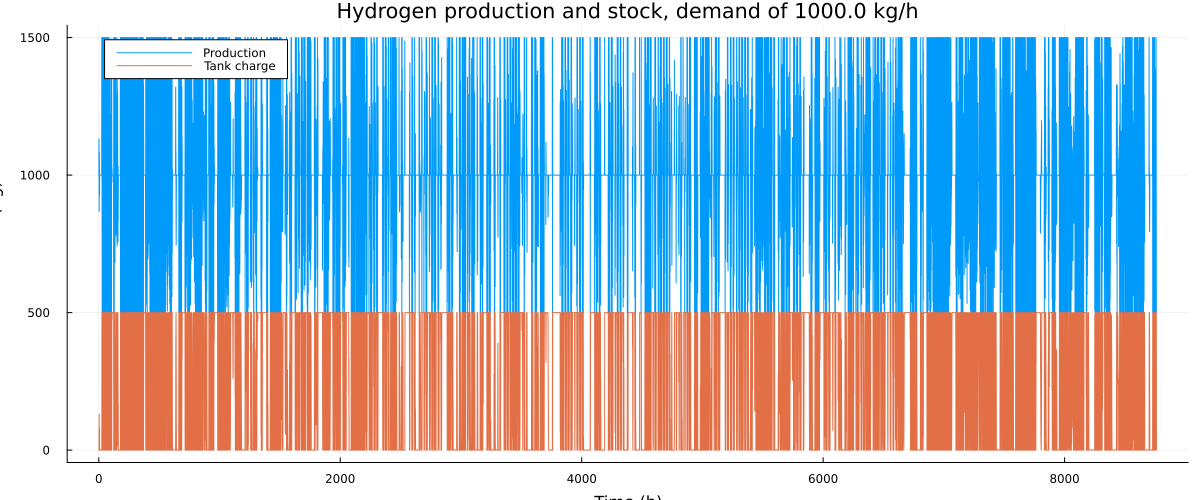

In [29]:
# Plot the production & tank charge over time
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)", title="Hydrogen production and stock, demand of $D kg/h")
plot!(prod_out, label="Production")
plot!(stock_out, label="Tank charge")

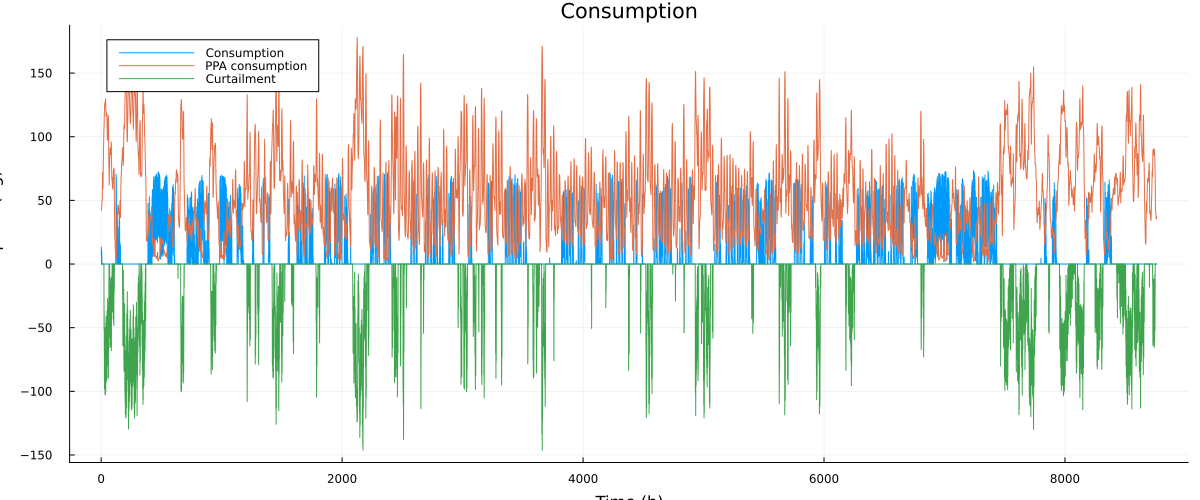

In [30]:
# Plot the consumptions, curtailment and battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Consumption (Kg)", title="Consumption")
plot!(elec_out, label="Consumption")
plot!(consPPA_out, label="PPA consumption")
plot!(-curtailment_out, label="Curtailment")

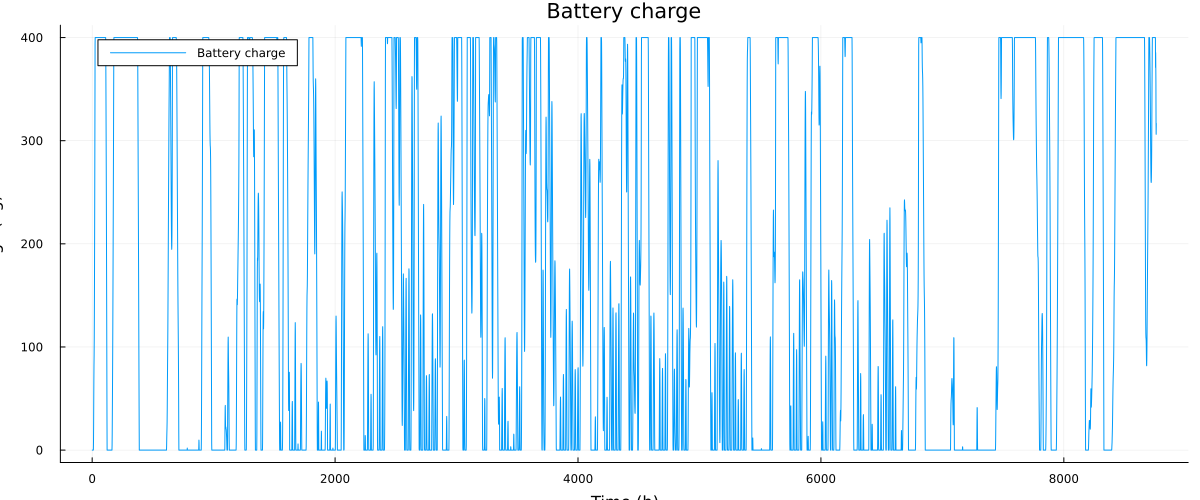

In [31]:
# Plot the battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Charge (Kg)", title="Battery charge")
plot!(charge_out, label="Battery charge")